<a href="https://colab.research.google.com/github/TheOnesThatWereAbroad/Assignment1/blob/main/POS_tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1 - POS tagging

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

from data_input import DataInput
from text_vectorizer import TextVectorizer, TargetVectorizer

## 1. Build a dataset

### 1.1 Dataset preparation
For this experiment, the [Dependency Parsed Treebank](https://www.nltk.org/nltk_data/) dataset is used.

In [2]:
# download the dataset and split it into train, dev and test sets
dataset = DataInput(
        data_url="https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip",
        train_size=0.50,
        dev_size=0.25,
        dataset_folder=os.path.join(os.getcwd(), "dataset"),
        split_into_sentences=True,
        shuffle=False
    )

Train set size: 1957
Dev set size: 979
Test set size: 978


Pre-processing is always an important step with which start. There are a lot of pre-processing steps that we can consider, but for this experiment the only pre-processing operation performed is:
- **to lower**, in part-of-speech tagging scenario casing of the input tokens is crucial to find the correspondent token in the embedding vocabulary

In [3]:
# do preprocessing for train, validation and test sets
dataset.preprocessing("train", to_lower=True)
dataset.preprocessing("dev", to_lower=True)
dataset.preprocessing("test", to_lower=True)

# separate inputs and targets
X_train, y_train = dataset.train
X_dev, y_dev = dataset.dev
X_test, y_test = dataset.test

In [4]:
dataset.train[0].shape

(1957,)

### 1.2 Dataset analysis
Let's take a look at the dataset, to inspect the distribution of the POS tags

In [5]:
def get_occurences(data, ordered=False, exclude=[]):
    """
    Get the occurences of each token in the data.

    Parameters
    ----------
    data : list of np arrays, representing the data to get the occurences from
    ordered : bool, if True, the occurences will be returned in descending order
    exclude : list of strings, tokens that should not be included in the occurences

    Returns
    -------
    occurences : dict, mapping each token to the number of occurences
    """
    tokens, counts = np.unique(np.concatenate(data), return_counts=True)
    occurences = dict(zip(tokens, counts))

    if len(exclude) > 0:
        for token in exclude:
            if token in occurences:
                del occurences[token]

    if ordered:
        occurences = dict(sorted(occurences.items(), key=lambda x: x[1], reverse=True))
    return occurences

# get the occurences of each POS tag in the three sets 
train_tags_occ = get_occurences(y_train, ordered=True, exclude=[])
dev_tags_occ = get_occurences(y_dev, exclude=[])
test_tags_occ = get_occurences(y_test, exclude=[])

# build a matrix of the occurences of size (n_tags, 3)
tags_occ = np.array([[v, dev_tags_occ[k], test_tags_occ[k]] if k in dev_tags_occ and k in test_tags_occ else [v, dev_tags_occ[k], 0] if k in dev_tags_occ else [v, 0, test_tags_occ[k]] if k in test_tags_occ else [v, 0, 0] for k, v in train_tags_occ.items()])

[]

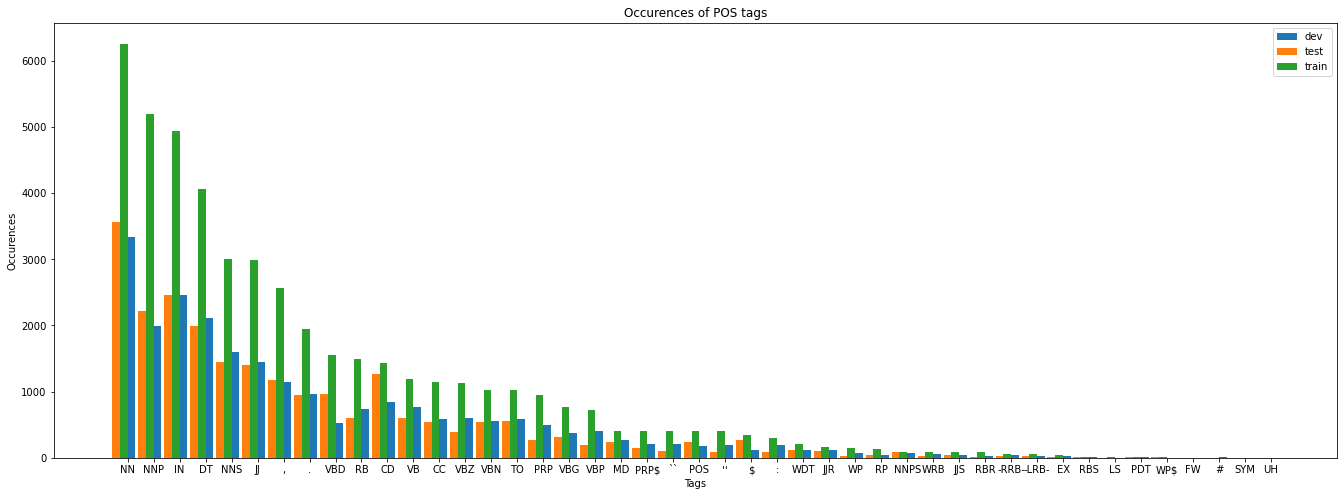

In [6]:
# plot bar chart of the occurences of each POS tag
fig, ax = plt.subplots(1, 1, figsize=(23, 8))
tags = list(train_tags_occ.keys())
ax.bar(tags, tags_occ[:, 1], width=0.3, align='edge', label='dev')
ax.bar(tags, tags_occ[:, 2], width=-0.6, align='edge', label='test')
ax.bar(tags, tags_occ[:, 0], width=-0.3, align='edge', label='train')
ax.set_xticks(tags)
ax.set_xlabel('Tags')
ax.set_ylabel('Occurences')
ax.set_title("Occurences of POS tags")
ax.legend()
plt.plot()

In [7]:
# analyze the difference between the presence of the POS tags in the train, dev and test sets
train_tags_not_dev = set(train_tags_occ.keys()) - set(dev_tags_occ.keys())
train_tags_not_test = set(train_tags_occ.keys()) - set(test_tags_occ.keys())
dev_tags_not_train = set(dev_tags_occ.keys()) - set(train_tags_occ.keys())
test_tags_not_train = set(test_tags_occ.keys()) - set(train_tags_occ.keys())

if(len(train_tags_not_dev) > 0):
    print("The following tags (from the train set) are not in the dev set:", train_tags_not_dev)
if(len(train_tags_not_test) > 0):
    print("The following tags (from the train set) are not in the test set:", train_tags_not_test)
if(len(dev_tags_not_train) > 0):
    print("The following tags (from the dev set) are not in the train set:", dev_tags_not_train)
if(len(test_tags_not_train) > 0):
    print("The following tags (from the test set) are not in the train set:", test_tags_not_train)

The following tags (from the train set) are not in the dev set: {'SYM'}
The following tags (from the train set) are not in the test set: {'SYM', 'UH', 'FW', 'LS'}


### 1.3 GloVe embeddings vectorization
The next step consists in downloading a pre-trained embedding model, namely GloVe. It is a techniques that tries to encoded global semantic properties based on the co-occurrence matrix.
Three different dimensional space versions are available: 50, 100, 200.

From the choosen embedding, a starting vocabulary is built.
Then this vocabulary is enriched with the embeddings computed for the OOV words.

In [8]:
# initialize the vectorizer for the input tokens to convert them to embedding vectors
# and build the vocabulary V1 from the glove embeddings
text_vectorizer = TextVectorizer(
    glove_url="http://nlp.stanford.edu/data/glove.6B.zip",
    max_tokens=20000,
    embedding_dim=50,
    embedding_folder=os.path.join(os.getcwd(), "glove"),
    max_size=dataset.max_size
)

# compute embeddings for terms (OOV1) in the training set that are out of vocabulary V1 and add them: V2=V1+OOV1
print("Parsing the training set...")
text_vectorizer.adapt(X_train)
# use the vocabulary V2 to convert the training set inputs into embedding vectors
X_train = text_vectorizer.transform(X_train)

# compute embeddings for terms (OOV2) in the validation set that are out of vocabulary V2 and add them: V3=V2+OOV2
print("\nParsing the validation set...")
text_vectorizer.adapt(X_dev)
# use the vocabulary V3 to convert the validation set inputs into embedding vectors
X_dev = text_vectorizer.transform(X_dev)

# compute embeddings for terms (OOV3) in the test set that are out of vocabulary V3 and add them: V4=V3+OOV3
print("\nParsing the test set...")
text_vectorizer.adapt(X_test)
# use the vocabulary V4 to convert the test set inputs into embedding vectors
X_test = text_vectorizer.transform(X_test)

Parsing the training set...
Generated embeddings for 358 OOV words.

Parsing the validation set...
Generated embeddings for 131 OOV words.

Parsing the test set...
Generated embeddings for 187 OOV words.


In [9]:
print(f"Input shape: {X_train.shape}")

Input shape: (1957, 249, 50)


### 1.4 One-hot encoding of the targets
Each POS tag in each set is converted using the one-hot representation

In [10]:
# initialize the vectorizer for the target tags to convert them into one-hot representation
target_vectorizer = TargetVectorizer(max_size=dataset.max_size)

# adapt the target vectorizer with only the training set: we do not consider possible targets that are not seen in training set but they are in the dev/test set
target_vectorizer.adapt(y_train)  

# convert the targets into one-hot representation for each splitting set
y_train = target_vectorizer.transform(y_train)
y_dev = target_vectorizer.transform(y_dev)
y_test = target_vectorizer.transform(y_test)

n_classes = y_train[0].shape[1]

In [11]:
print(f"Target shape: {y_train.shape}")
print(f"Number of classes for one-hot encoded targets: {n_classes}")

Target shape: (1957, 249, 45)
Number of classes for one-hot encoded targets: 45


## 2. Training

### 2.1 Models definition
We are now ready to define our neural network architectures!

In [12]:
def create_model(layers_info, compile_info):
    """
    Create a Keras model given a list of layer information

    Parameters
    ----------
    layers_info : a list of dictionaries, one for each layer
    compile_info : dictionary containing compile information

    Returns
    -------
    model: the built keras sequential model
    """

    model = keras.Sequential()
    for info in layers_info:
        layer = info['layer_name'](**{key: value for key, value in info.items() if key != 'layer_name'})
        model.add(layer)

    # Compile
    model.compile(**compile_info)

    return model

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
    
layers_info = [
    {
        "layer_name": layers.Masking,
        "name": "padding_masking",
        "mask_value": 0.
    },
    {
        'layer_name': layers.Bidirectional,
        "layer": layers.LSTM(64, return_sequences=True),
        "name": "bilstm_1",
    },
    {
        "layer_name": layers.Dense,
        "units": n_classes,
        "activation": "softmax",
        "name": "output"
    }
]

compile_info = {
    'optimizer': keras.optimizers.Adam(learning_rate=1e-3),
    'loss': 'categorical_crossentropy',
    'metrics' : [get_f1]
}

model = create_model(layers_info, compile_info)
model.build(input_shape=X_train.shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 padding_masking (Masking)   (1957, 249, 50)           0         
                                                                 
 bilstm_1 (Bidirectional)    (1957, 249, 128)          58880     
                                                                 
 output (Dense)              (1957, 249, 45)           5805      
                                                                 
Total params: 64,685
Trainable params: 64,685
Non-trainable params: 0
_________________________________________________________________


### 2.2 Model training

In [13]:
history_bilstm = model.fit(X_train, y_train, epochs=30, batch_size=12, validation_data=(X_dev, y_dev))

Epoch 1/30
164/164 [==============================] - 15s 35ms/step - loss: 0.2293 - get_f1: 0.1198 - val_loss: 0.1519 - val_get_f1: 0.4614
Epoch 2/30
164/164 [==============================] - 3s 21ms/step - loss: 0.1173 - get_f1: 0.6017 - val_loss: 0.1028 - val_get_f1: 0.6708
Epoch 3/30
164/164 [==============================] - 3s 21ms/step - loss: 0.0881 - get_f1: 0.7258 - val_loss: 0.0855 - val_get_f1: 0.7291
Epoch 4/30
164/164 [==============================] - 3s 20ms/step - loss: 0.0742 - get_f1: 0.7720 - val_loss: 0.0756 - val_get_f1: 0.7623
Epoch 5/30
164/164 [==============================] - 3s 20ms/step - loss: 0.0656 - get_f1: 0.7998 - val_loss: 0.0691 - val_get_f1: 0.7844
Epoch 6/30
164/164 [==============================] - 3s 21ms/step - loss: 0.0592 - get_f1: 0.8192 - val_loss: 0.0643 - val_get_f1: 0.7988
Epoch 7/30
164/164 [==============================] - 4s 22ms/step - loss: 0.0541 - get_f1: 0.8347 - val_loss: 0.0607 - val_get_f1: 0.8101
Epoch 8/30
164/164 [======

### 2.3 History of the training
Plot metrics evolution for each epoch during the training

In [17]:
def plot_history(models_history, keys, model_names=[], labels=("epochs", "metrics"), figsize=(10,5), cmap='rainbow'):
    """
    Plot the history of the metrics in the history dictionary for each model.
        :param models_history: array of dictionary of the metric history for each model
        :param keys: list of keys of the metrics to plot
        :param model_names: list of names of the models
        :param labels: list of labels of the axes
        :param figsize: size of the figure
        :param cmap: color map used for the plot
    """

    # maps each model to a distinct RGB color
    cmap = plt.cm.get_cmap(cmap, len(models_history))

    
    fig = plt.figure(figsize=figsize)

    # for each model trained
    for i, history in enumerate(models_history):
        # take all pairs of training and val metrics
        for j in range(0, len(keys), 2):
            metric, val_metric = keys[j], keys[j+1]
            
            plt.plot(history[metric], label=f"{model_names[i]} {metric}", linestyle="solid", color=cmap(i))
            plt.plot(history[val_metric],  label=f"{model_names[i]} {val_metric}", linestyle="--",  color=cmap(i))
        
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])

    # Adding legend
    plt.legend(
          title ="Legend",
          loc ="upper left",
          bbox_to_anchor =(1.0, 0, 0.5, 1))
    plt.title("Training history")
    plt.grid(linestyle='--', linewidth=1)
    plt.show()

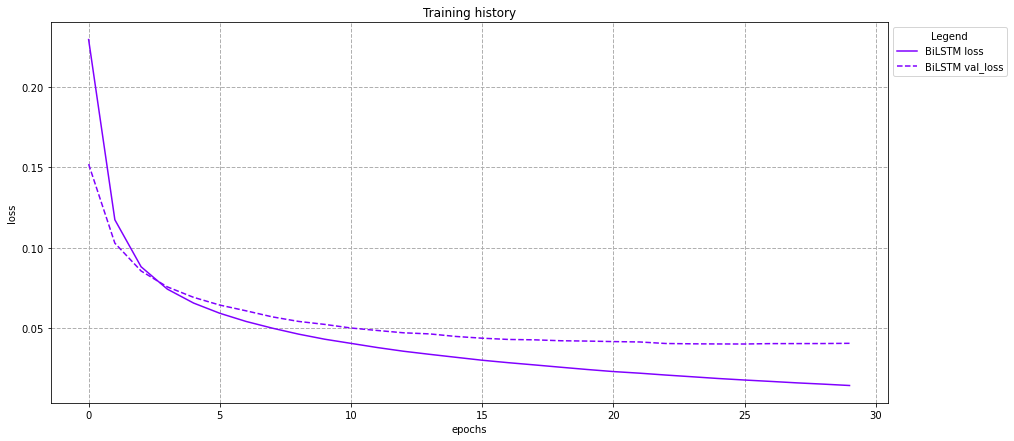

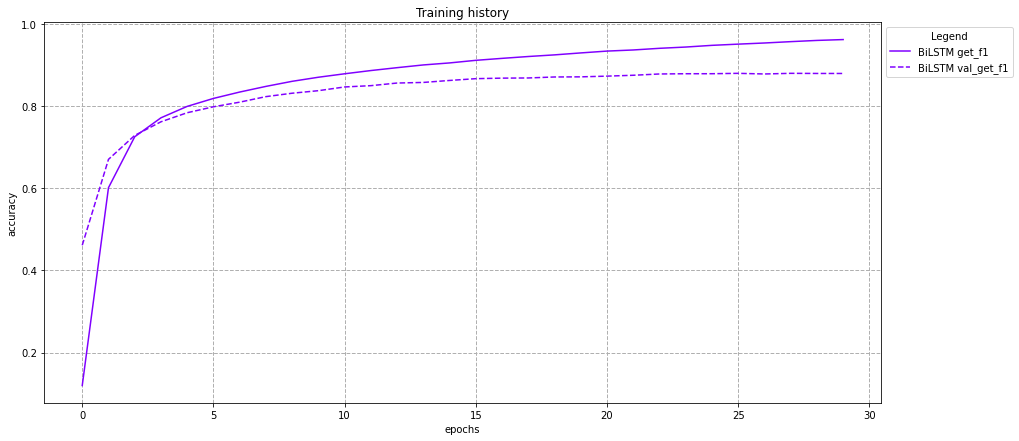

In [18]:
models_history = [history_bilstm.history]
model_names = ["BiLSTM"]
plot_history(models_history, keys=['loss', 'val_loss'], model_names=model_names, labels=("epochs", "loss"), figsize=(15,7))
plot_history(models_history, keys=['get_f1', 'val_get_f1'], model_names=model_names, labels=("epochs", "accuracy"), figsize=(15,7))

## 3. Evaluation

In [19]:
def evaluate_model(model, X_test, y_test, labels):
    """
    given a trained model and a test set returns the f-score and the confusion matrix
    taking into account only classes in labels
    """
    raw_y_true = np.array(y_test)
    raw_y_pred = model.predict(X_test)
    # shape of the output is doc x len_sen x classes
    # argmax for label predictions
    len_sentence = raw_y_pred.shape[1]
    num_sentences = raw_y_pred.shape[0]
    y_pred = np.empty((num_sentences, len_sentence))
    y_true = np.empty((num_sentences, len_sentence))
    # assign label with the highest probability
    for i in range(num_sentences):
        for j in range(len_sentence):
            y_pred[i,j] = np.argmax(raw_y_pred[i,j,:])
            y_true[i,j] = np.argmax(raw_y_true[i,j,:])
    # flatten the numpy array to have a 1D array
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    # show confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(conf_matrix)
    disp.plot()
    plt.show()
    # f1 score
    print("F score:\n-------------------------------\n")
    print(f1_score(y_true, y_pred, labels=labels, average='macro'))

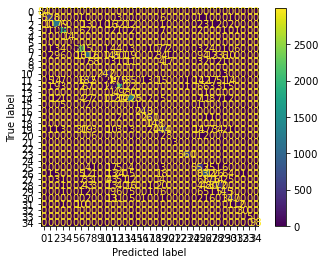

F score:
-------------------------------

0.6922703169104384


C:\Users\peppe\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [20]:
punctuation_indexes = [0, 1, 2, 3, 4, 5, 6, 16, 30, 43]
classes = target_vectorizer.get_classes()
valid_labels = list(set(range(len(classes))) - set(punctuation_indexes))
evaluate_model(model, X_test, y_test, valid_labels)

In [21]:
i_test = 4  # change this to see the prediction for a different sentence

print("Original POS tagging: ",target_vectorizer.inverse_transform([y_test[i_test]])[0])

raw_y_pred = model.predict(np.array([X_test[i_test]]))
# shape of the output is doc x len_sen x classes
# argmax for label predictions

print("Predicted POS tagging: ",target_vectorizer.inverse_transform_probabilities(raw_y_pred)[0])

Original POS tagging:  ['IN' 'DT' 'CD' ',' 'NNS' 'VBD' 'NN' 'NNS' 'IN' 'DT' 'NNS' 'IN' 'NNP'
 'NNS' '.']
Predicted POS tagging:  ['IN' 'DT' 'CD' ',' 'NNS' 'VBD' 'VBZ' 'NNS' 'IN' 'DT' 'NNS' 'IN' 'NNP'
 'NNS' '.']
